In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text, ax_text
from PIL import Image
import urllib
import seaborn as sns
from sqlalchemy import create_engine, text

In [2]:
# Database connection parameters
server_name = 'DESKTOP-F00PL4B\\SQLEXPRESS01'  # Double backslash to escape
database_name = 'PortfolioProject'

connection_url = f"mssql+pyodbc://@{server_name}/{database_name}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"

engine = create_engine(connection_url)

with engine.connect() as connection:
    query_results = text("SELECT * FROM WC_Results2324")
    query_hills = text("SELECT * FROM WC_Calendar2324")
    df_results = pd.read_sql(query_results,connection)
    df_hills = pd.read_sql(query_hills, connection)

In [3]:
df_results.head()

,Result_ID,WC_ID,Standing_ID,Miasto,Miejsce,Zawodnik,Kraj,Skok_1,Skok_2,Skok_3,Nota
0,1,1,1.0,Ruka,1.0,KRAFT Stefan,AUT,144.0,143.0,NaN,326.2
1,2,1,10.0,Ruka,2.0,PASCHKE Pius,DEU,142.0,142.5,NaN,315.6
2,3,1,23.0,Ruka,3.0,LEYHE Stephan,DEU,137.0,143.5,NaN,313.2
3,4,1,3.0,Ruka,4.0,WELLINGER Andreas,DEU,142.0,136.0,NaN,311.5
4,5,1,11.0,Ruka,5.0,TSCHOFENIG Daniel,AUT,136.0,140.5,NaN,310.3


In [4]:
df_hills.head()

,ID,WC_Date,Miasto,K_Point,HS_Point,Zawody
0,1,2023-11-25,Ruka,120,142,indywidualne
1,2,2023-11-26,Ruka,120,142,indywidualne
2,3,2023-12-02,Lillehammer,90,98,indywidualne
3,4,2023-12-03,Lillehammer,123,140,indywidualne
4,5,2023-12-09,Klingenthal,125,140,indywidualne


In [6]:
df_hills = df_hills.loc[:,["ID","Miasto","HS_Point"]]

In [8]:
df = df_results.merge(df_hills,left_on="WC_ID",right_on="ID", how="left", suffixes=("_res","_cal"))

In [9]:
df.head()

,Result_ID,WC_ID,Standing_ID,Miasto_res,Miejsce,Zawodnik,Kraj,Skok_1,Skok_2,Skok_3,Nota,ID,Miasto_cal,HS_Point
0,1,1,1.0,Ruka,1.0,KRAFT Stefan,AUT,144.0,143.0,NaN,326.2,1,Ruka,142
1,2,1,10.0,Ruka,2.0,PASCHKE Pius,DEU,142.0,142.5,NaN,315.6,1,Ruka,142
2,3,1,23.0,Ruka,3.0,LEYHE Stephan,DEU,137.0,143.5,NaN,313.2,1,Ruka,142
3,4,1,3.0,Ruka,4.0,WELLINGER Andreas,DEU,142.0,136.0,NaN,311.5,1,Ruka,142
4,5,1,11.0,Ruka,5.0,TSCHOFENIG Daniel,AUT,136.0,140.5,NaN,310.3,1,Ruka,142


In [10]:
df = df.loc[:,["WC_ID","Miasto_res","Skok_1","Skok_2","Skok_3","HS_Point"]]

In [11]:
df.head()

,WC_ID,Miasto_res,Skok_1,Skok_2,Skok_3,HS_Point
0,1,Ruka,144.0,143.0,NaN,142
1,1,Ruka,142.0,142.5,NaN,142
2,1,Ruka,137.0,143.5,NaN,142
3,1,Ruka,142.0,136.0,NaN,142
4,1,Ruka,136.0,140.5,NaN,142


In [12]:
df_melted = df.melt(
    id_vars=["WC_ID","Miasto_res","HS_Point"],
    value_vars=["Skok_1", "Skok_2", "Skok_3"],
    var_name="Skok_nr",
    value_name="Dlugosc_skoku"
)

In [14]:
df_melted.reset_index(drop=True, inplace=True)

In [ ]:
df_melted = df_melted.loc[df_melted["Dlugosc_skoku"] != 0]

In [19]:
df_jumps = df_melted.dropna(subset=["Dlugosc_skoku"], how="any", axis=0).reset_index(drop=True)

In [20]:
df_jumps.head()

,WC_ID,Miasto_res,HS_Point,Skok_nr,Dlugosc_skoku
0,1,Ruka,142,Skok_1,144.0
1,1,Ruka,142,Skok_1,142.0
2,1,Ruka,142,Skok_1,137.0
3,1,Ruka,142,Skok_1,142.0
4,1,Ruka,142,Skok_1,136.0


In [22]:
df_jumps['IsAbove'] = (df_jumps['Dlugosc_skoku'] > df_jumps['HS_Point']).astype(int)

In [23]:
df_jumps.head()

,WC_ID,Miasto_res,HS_Point,Skok_nr,Dlugosc_skoku,IsAbove
0,1,Ruka,142,Skok_1,144.0,1
1,1,Ruka,142,Skok_1,142.0,0
2,1,Ruka,142,Skok_1,137.0,0
3,1,Ruka,142,Skok_1,142.0,0
4,1,Ruka,142,Skok_1,136.0,0


In [35]:
Above_count = np.round(df_jumps.loc[df_jumps['IsAbove']==1,"IsAbove"].count()/df_jumps["IsAbove"].count(),2)
Under_count = np.round(df_jumps.loc[df_jumps['IsAbove']==0,"IsAbove"].count()/df_jumps["IsAbove"].count(),2)

In [36]:
print(Above_count, Under_count)

0.05 0.95


In [37]:
df_total = pd.DataFrame(data=[["Konkursy PŚ Razem",Above_count,Under_count]],columns=["World_Cup_no","Above_count","Under_count"])

In [38]:
df_total.set_index("World_Cup_no",inplace=True)

In [39]:
df_total

,Above_count,Under_count
World_Cup_no,,
Konkursy PŚ Razem,0.05,0.95


In [44]:
df_hs = df_jumps.groupby(["WC_ID","Miasto_res","HS_Point"])['IsAbove'].agg(
    Above_count=lambda x: np.round((x==1).sum()/x.count(),2),
    Under_count=lambda x: np.round((x==0).sum()/x.count(),2)
).reset_index()

In [45]:
df_hs

,WC_ID,Miasto_res,HS_Point,Above_count,Under_count
0,1,Ruka,142,0.09,0.91
1,2,Ruka,142,0.18,0.82
2,3,Lillehammer,98,0.06,0.94
3,4,Lillehammer,140,0.04,0.96
4,5,Klingenthal,140,0.12,0.88
5,6,Klingenthal,140,0.11,0.89
6,7,Engelberg,140,0.01,0.99
7,8,Engelberg,140,0.04,0.96
8,9,Oberstdorf,137,0.04,0.96
9,10,Garmisch-Partenkirchen,142,0.00,1.00


In [50]:
df_hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   WC_ID        32 non-null     int64  
 1   Miasto_res   32 non-null     object 
 2   HS_Point     32 non-null     int64  
 3   Above_count  32 non-null     float64
 4   Under_count  32 non-null     float64
 5   (28, 1)      32 non-null     object 
 6   (30, 1)      32 non-null     object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.9+ KB


In [62]:
df_hs.iloc[28,1]='Vikersund'
df_hs.iloc[29,1]='Vikersund'

In [63]:
df_hs

,WC_ID,Miasto_res,HS_Point,Above_count,Under_count
0,1,Ruka,142,0.09,0.91
1,2,Ruka,142,0.18,0.82
2,3,Lillehammer,98,0.06,0.94
3,4,Lillehammer,140,0.04,0.96
4,5,Klingenthal,140,0.12,0.88
5,6,Klingenthal,140,0.11,0.89
6,7,Engelberg,140,0.01,0.99
7,8,Engelberg,140,0.04,0.96
8,9,Oberstdorf,137,0.04,0.96
9,10,Garmisch-Partenkirchen,142,0.00,1.00


In [64]:
df_hs["World_Cup_no"] = df_hs["WC_ID"].astype(str) + " " + df_hs["Miasto_res"]

In [69]:
#df_hs_viz
df_viz = df_hs.loc[:,["World_Cup_no","Above_count","Under_count"]].set_index(["World_Cup_no"])

In [70]:
df_viz

,Above_count,Under_count
World_Cup_no,,
1 Ruka,0.09,0.91
2 Ruka,0.18,0.82
3 Lillehammer,0.06,0.94
4 Lillehammer,0.04,0.96
5 Klingenthal,0.12,0.88
6 Klingenthal,0.11,0.89
7 Engelberg,0.01,0.99
8 Engelberg,0.04,0.96
9 Oberstdorf,0.04,0.96


In [71]:
df_total

,Above_count,Under_count
World_Cup_no,,
Konkursy PŚ Razem,0.05,0.95


In [75]:
df_viz_total = pd.concat([df_viz,df_total],axis=0)

In [76]:
df_viz_total

,Above_count,Under_count
World_Cup_no,,
1 Ruka,0.09,0.91
2 Ruka,0.18,0.82
3 Lillehammer,0.06,0.94
4 Lillehammer,0.04,0.96
5 Klingenthal,0.12,0.88
6 Klingenthal,0.11,0.89
7 Engelberg,0.01,0.99
8 Engelberg,0.04,0.96
9 Oberstdorf,0.04,0.96


In [102]:
def plot_horizontal_bar_chart_multiindex(df):
    
    column_colors = {
        'Above_count': "#FF905C",
        'Under_count': "#5D8EAF"
    }

    labels = df.index.tolist()
    data = df.values
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(15,10),facecolor="#EEE9E6", dpi=200)

    ax.set_facecolor("#EEE9E5")
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0,np.sum(data, axis=1).max())
    ax.grid(False)
    ax.grid(axis='x', linestyle='--', color="#B2B2B2", zorder=0)

    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    
    bar_height = 1.25
    group_spacing = 2.4
    y_positions = np.arange(len(labels)) * group_spacing

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, weight="bold")

    for i, colname in enumerate(df.columns):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(y_positions, widths, left=starts, height=bar_height,
                        label=colname, color=column_colors[colname], alpha=0.95, zorder=2)

        for rect in rects:
            width = rect.get_width()
            if width > 0:
                ax.text(
                    rect.get_x() + width / 2 + 0.003,
                    rect.get_y() + rect.get_height()/2,
                    f"{width:.00%}",
                    ha="center", va="center", color="w", fontsize=8, fontweight='bold'
                )

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))         

    margin_ax = fig.add_axes([0,1,0.02,0.02])           
    margin = margin_ax.patch
    margin.set_facecolor("#EEE9E6")

    margin_ax.spines["top"].set_visible(False)
    margin_ax.spines["bottom"].set_visible(False)
    margin_ax.spines["left"].set_visible(False)
    margin_ax.spines["right"].set_visible(False)

    margin_ax.xaxis.set_ticks([])
    margin_ax.yaxis.set_ticks([])

    bbox_pad = 1.5
    bboxprops = {'linewidth': 0, 'pad': bbox_pad}

    fig_text(
    x=0.15, y=.96, 
    s='Puchar Świata w Skokach Narciarskich 2023/2024: Punkt K - granica sukcesu?',
    va='bottom', ha='left',
    fontsize=19, color='black', font='DM Sans', weight='bold'
    )

    fig_text(
	x=0.15, y=.908, 
    s='Procentowy udział skoków <POWYŻEJ> oraz <PONIŻEJ> punktu K w konkursach PŚ, determinuje poziom sportowy danego konkursu, \njego widowiskowość oraz panujące warunki wietrzne. | viz by Paweł Jaszczerski',
	va='bottom', ha='left',
	fontsize=13, color='#4E616C', font='Karla',
    highlight_textprops=[
        {'color': 'w', 'fontweight': 'bold', 'bbox': {'facecolor':'#ff905c', **bboxprops}},
        {'color': 'w', 'fontweight': 'bold', 'bbox': {'facecolor':'#5d8eaf', **bboxprops}}
    ]
    )

    logo_url = 'I:/Projects/Skoki Narciarskie Sezon 2023_2024/FIS_Ski.png'
    logo_ax = fig.add_axes(
    [0.02, .89, .12, .12]
    )

    club_icon = Image.open(logo_url)
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    return fig, ax

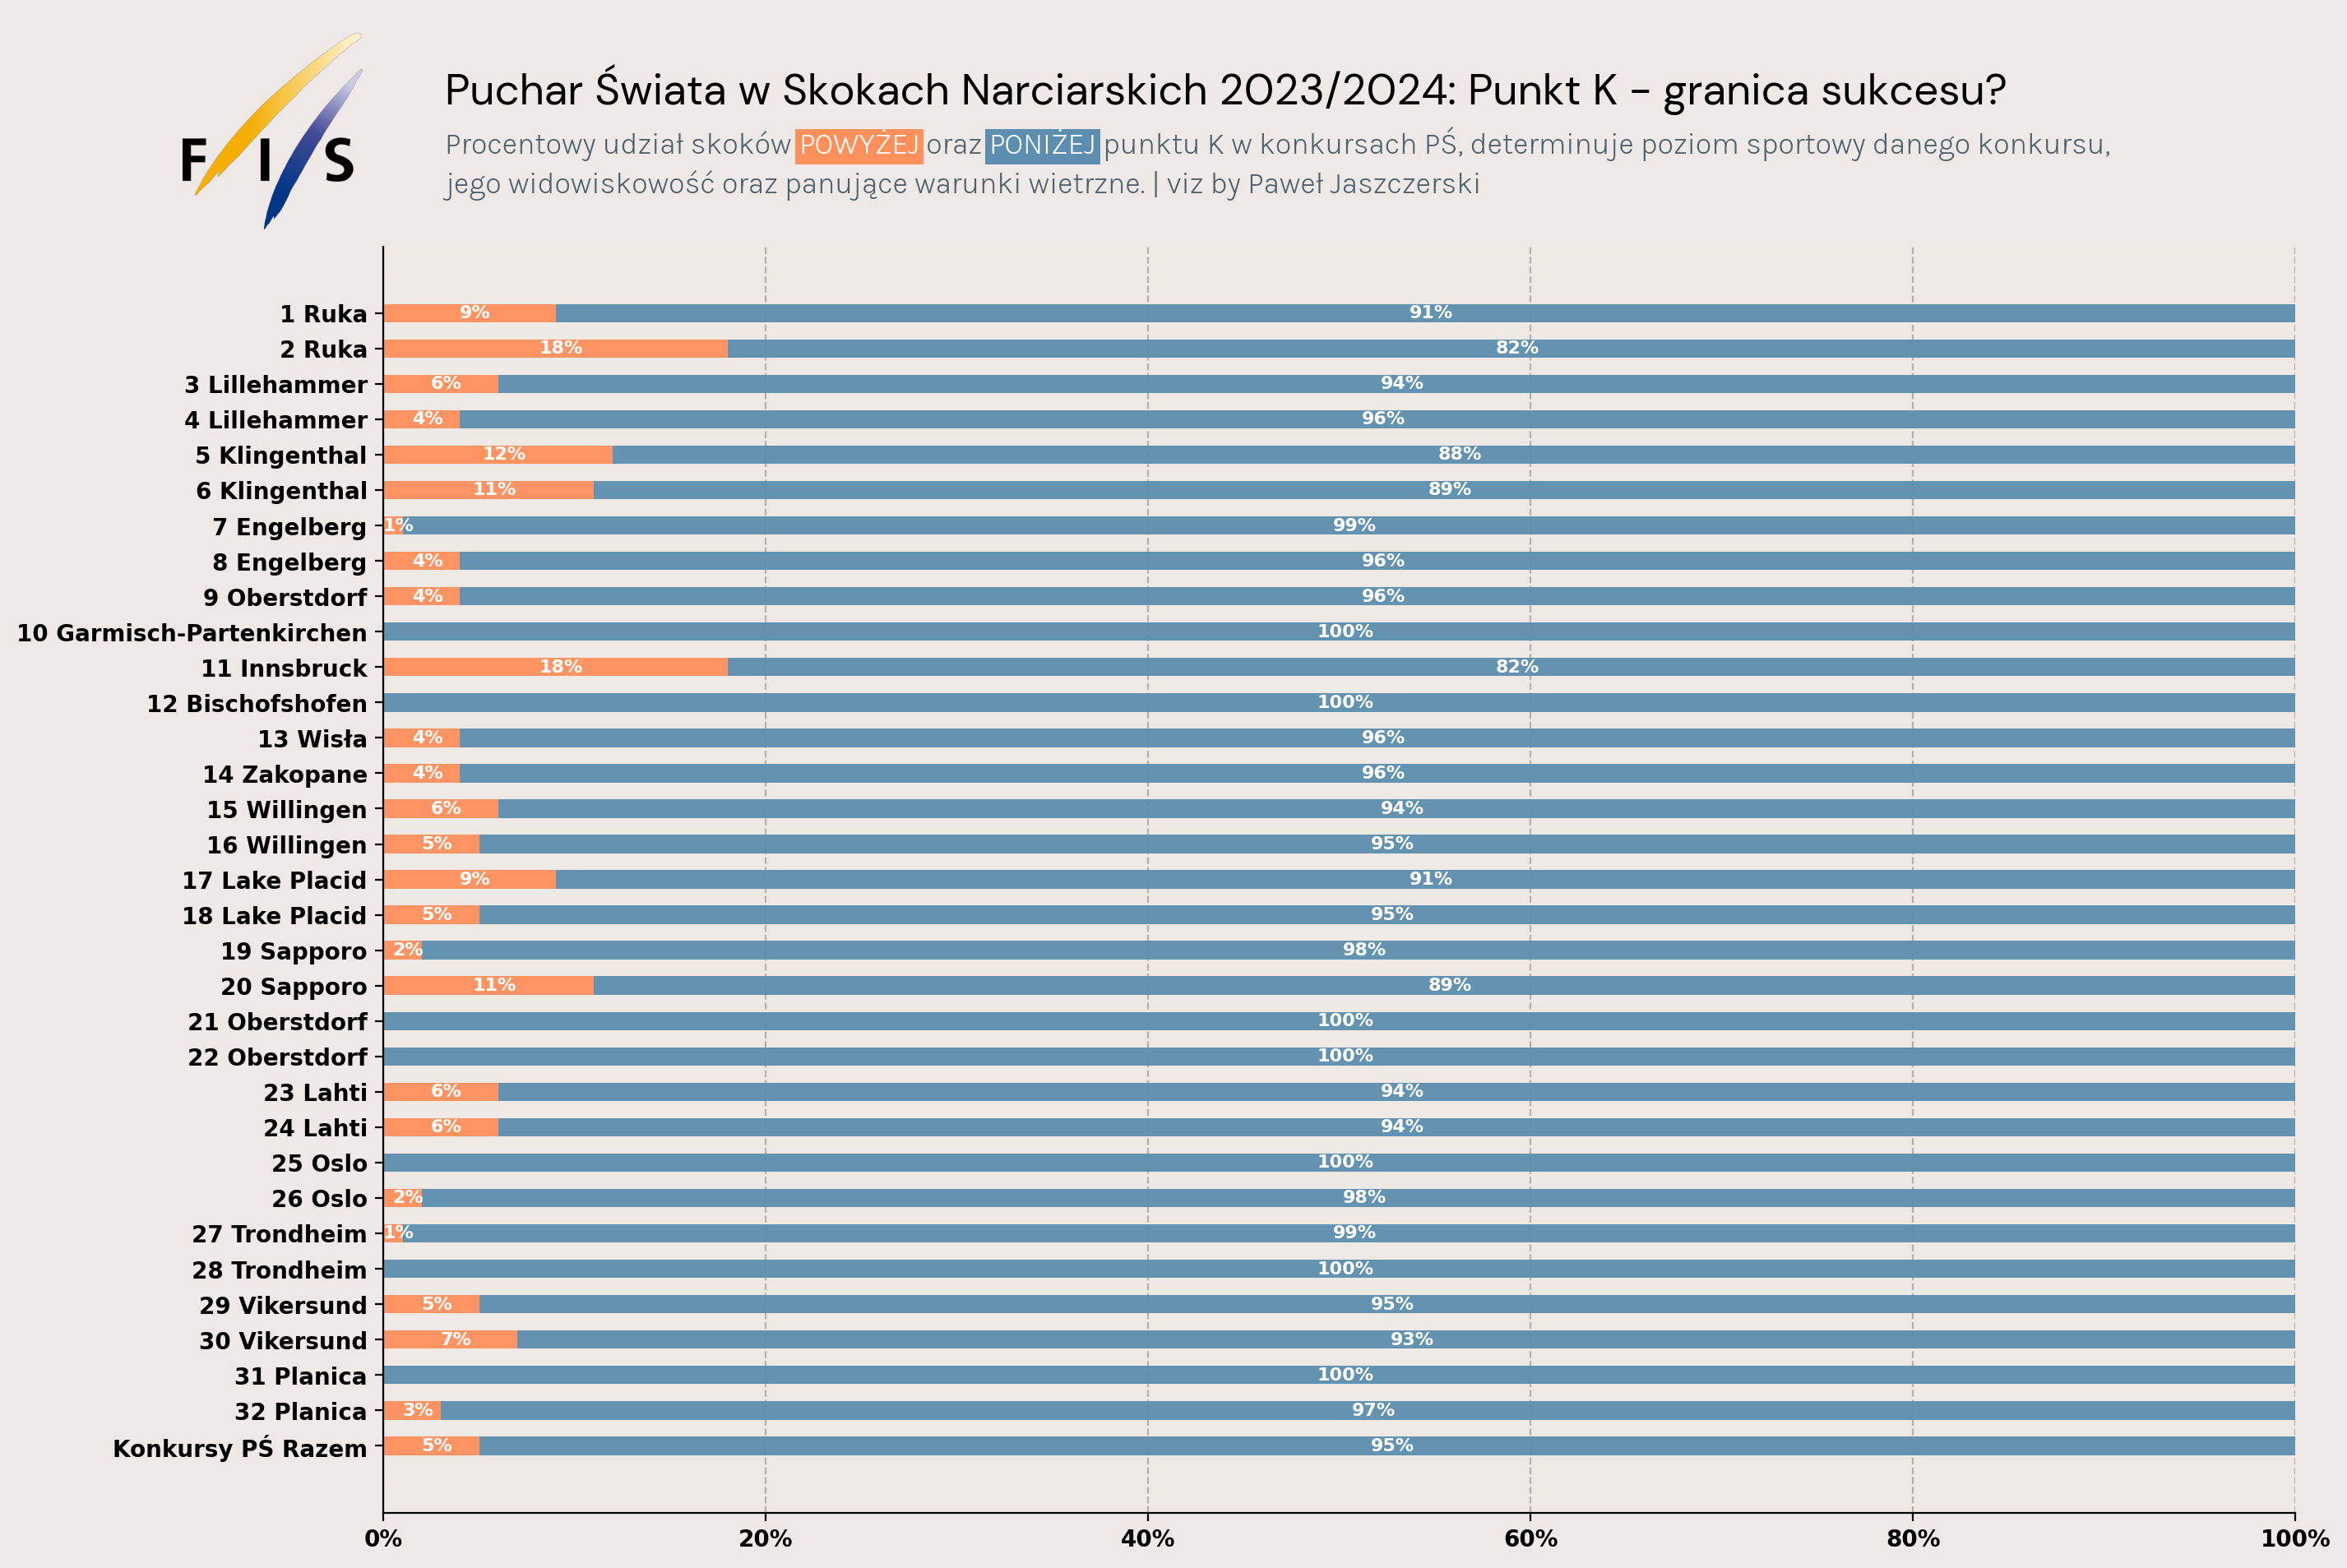

In [103]:
plot_horizontal_bar_chart_multiindex(df_viz_total)
plt.show()